<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from pandas_datareader import data as pdr
from bs4 import BeautifulSoup
import yfinance as yf
import datetime

# Задание 1.

Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Волшебный белый порошок" (ВБП), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на ВБП. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.

### Дополнительные вводные:

Так как продукт Б новый, возможно стоит предложить дисконт от цены Продукта А. Продукт производиться из нефти. Один из известных способов производства предполагает что из 16 баррелей нефти сделают одну тонну ВБП, а затраты на производство в районе 400 евро.

In [2]:
# Из данных есть:
# Цены на продукт А, который уже есть на рынке Европы
# ----- октябрь 2018 - 1600 евро
# ----- ноябрь 2018 - 1550 евро
# ----- февраль 2019 - 1600 евро

# Котировки нефти, курс eur/usd
dbc = pd.read_excel('cur_oil.xlsx')

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии) 
customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [ ]:
dbc

In [3]:
dbc.date = pd.to_datetime(dbc.Date)

<ipython-input-3-905a1ebe1346>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dbc.date = pd.to_datetime(dbc.Date)


<AxesSubplot:xlabel='Date'>

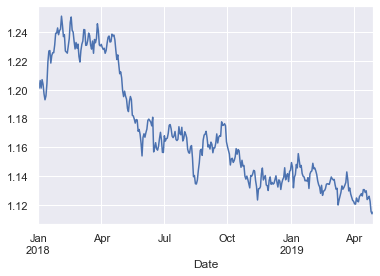

In [4]:
dbc_usd = dbc.set_index('Date')['EURUSD=X']
dbc_usd.plot()

<AxesSubplot:xlabel='Date'>

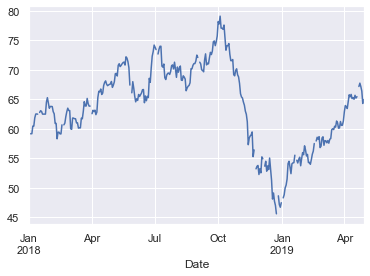

In [5]:
dbc_oil = dbc.set_index('Date')['OIL']
dbc_oil.plot()

In [ ]:
#Исходя из данных графиком, цена нефти имеет слабую связь с отношением евро к доллару.

In [ ]:
# Формула ВБП = 16 бареллей нефти + 400$ затрат на производство - 1 до 10 % скидка в зависимости от объема.

In [36]:
# Программа для рассчета цены 
def custom_order():
    # Дата сегодня
    today = datetime.datetime.now()
    today = today.strftime("%Y-%m-%d")

    # Цена нефти
    oil = yf.download('CL=F', today)
    oil = oil['Close'].to_list()
    oil = oil[0]

    # Отношение евро к доллару
    eu = yf.download('EURUSD=X', today)
    eu = eu['Close'].to_list()
    eu = eu[0]

    # Затраты на производство
    PRODUCTION_COST = 400 * eu

    # Расходы на логистику
    EU_LOGISTIC_COST_EUR = 30 * eu  # в Европу в евро
    CN_LOGISTIC_COST_USD = 130  # в Китай в долларах

    # Дисконт
    up_to_100 = 0.99
    up_to_300 = 0.95
    plus_300 = 0.9
    # Список клмиентов
    clients = []

    quest = (input("Вы хотите рассчитать данные по клиенту(Y/N)?")).lower()
    while quest == 'y':
        # Данные клиента
        customers = input('Введите наименование контрагента: ')
        location = (input('Введите локацию доставки(CN или EU): ')).lower()
        volumes = int(input('Введите объем(в тоннах): '))
        comment = input('Ваши комментарии: ')


        # Формула порошка
        mwp = 16 * oil + PRODUCTION_COST

        if location == 'cn':
            price = mwp * volumes + CN_LOGISTIC_COST_USD

            if volumes <= 100:
                price = price * up_to_100

            elif volumes > 100 and volumes < 300:
                price = price * up_to_300

            else:
                price = price * plus_300
        else:
            price = mwp * volumes + EU_LOGISTIC_COST_EUR

            if volumes <= 100:
                price = price * up_to_100

            elif volumes > 100 and volumes < 300:
                price = price * up_to_300

            else:
                price = price * plus_300

        client = [{'customers': customers,
                   'location': location,
                   'volumes': volumes,
                   'comment': comment,
                   'price': price}]
        clients.extend(client)
        quest = (input("Вы хотите рассчитать данные по клиенту(Y/N)?")).lower()
    df = pd.DataFrame(clients)
    doc = str(input('Введите под каким наименованием сохранить файл: '))
    writer = pd.ExcelWriter(f'./{doc}.xlsx')
    df.to_excel(writer)
    writer.save()
custom_order()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Вы хотите рассчитать данные по клиенту(Y/N)?y
Введите наименование контрагента: gazprom
Введите локацию доставки(CN или EU): eu
Введите объем(в тоннах): 150
Ваши комментарии: bla
Вы хотите рассчитать данные по клиенту(Y/N)?y
Введите наименование контрагента: lukoil
Введите локацию доставки(CN или EU): cn
Введите объем(в тоннах): 200
Ваши комментарии: bla
Вы хотите рассчитать данные по клиенту(Y/N)?n
Введите под каким наименованием сохранить файл: keys


Данная программа считает сумму к оплате для клиентов и сохраняет в Excel-файл.
Программа подтягивает данные из интернета :
    -текущая дата
    -EUR/USD
    -OIL
Иммется возможность назвать сохраненный файл.
Все цены указаны в долларах.
Все клиенты сохраняются в один файл.
Если делать программу для клиентов, то будет просто убран цикл с вопросом о вводе еще одного клиента.